# Executive Summary

This project analyzes portfolio construction and risk-return optimization using the **Markowitz Mean–Variance model** and the **Black–Litterman framework**.  
Real market data from major technology stocks were used to estimate expected returns and covariances.  
The classical Markowitz approach was first applied to derive the efficient frontier, minimum variance, and tangency portfolios.  
Subsequently, the Black–Litterman model incorporated equilibrium market expectations and subjective investor views to generate adjusted posterior returns.  
Results show that Black–Litterman portfolios are more stable, diversified, and robust to estimation error compared to the traditional Markowitz optimization.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.style.use("seaborn-v0_8-whitegrid")
np.set_printoptions(precision=6, suppress=True)

# Convenciones
TRADING_DAYS = 252

def annualize_returns(returns, periods_per_year=TRADING_DAYS):
    mu_daily = returns.mean()
    mu_ann = mu_daily * periods_per_year
    return mu_ann

def annualize_cov(returns, periods_per_year=TRADING_DAYS):
    return returns.cov() * periods_per_year

def portfolio_performance(weights, mu, cov):
    """Devuelve (retorno anual esperado, volatilidad anual, Sharpe con rf)."""
    w = np.asarray(weights)
    exp_ret = float(w @ mu)
    vol = float(np.sqrt(w @ cov @ w))
    return exp_ret, vol

def neg_sharpe(weights, mu, cov, rf):
    exp_ret, vol = portfolio_performance(weights, mu, cov)
    return -(exp_ret - rf) / (vol + 1e-12)

def min_variance(weights, mu, cov):
    _, vol = portfolio_performance(weights, mu, cov)
    return vol**2

def target_return_constraint(target, mu):
    return lambda w: float(w @ mu) - target

def weight_sum_constraint():
    return lambda w: np.sum(w) - 1.0


In [2]:
# Elige tickers (puedes cambiarlos libremente)
tickers = ["AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "META", "TSLA"]

start = "2018-01-01"
end   = None  # hasta hoy

prices = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"].dropna()
returns = prices.pct_change().dropna()

print(prices.tail(3))
print("\nRetornos diarios (muestra):")
print(returns.tail(3))


[*********************100%***********************]  7 of 7 completed

Ticker            AAPL        AMZN       GOOGL        META        MSFT  \
Date                                                                     
2025-10-23  259.579987  221.089996  253.080002  734.000000  520.559998   
2025-10-24  262.820007  224.210007  259.920013  738.359985  523.609985   
2025-10-27  268.809998  226.970001  269.269989  750.820007  531.520020   

Ticker            NVDA        TSLA  
Date                                
2025-10-23  182.160004  448.980011  
2025-10-24  186.259995  433.720001  
2025-10-27  191.490005  452.420013  

Retornos diarios (muestra):
Ticker          AAPL      AMZN     GOOGL      META      MSFT      NVDA  \
Date                                                                     
2025-10-23  0.004372  0.014407  0.005523  0.000804  0.000038  0.010428   
2025-10-24  0.012482  0.014112  0.027027  0.005940  0.005859  0.022508   
2025-10-27  0.022791  0.012310  0.035973  0.016875  0.015107  0.028079   

Ticker          TSLA  
Date                 

In [3]:
mu = annualize_returns(returns)      # vector de retornos esperados anuales
cov = annualize_cov(returns)         # matriz de covarianza anual

assets = mu.index.tolist()
n = len(assets)

print("Assets:", assets)
print("\nμ anual:\n", mu)
print("\nΣ anual (primeras filas):\n", cov.iloc[:5, :5])


Assets: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

μ anual:
 Ticker
AAPL     0.291426
AMZN     0.231015
GOOGL    0.255834
META     0.270333
MSFT     0.284838
NVDA     0.602426
TSLA     0.595651
dtype: float64

Σ anual (primeras filas):
 Ticker      AAPL      AMZN     GOOGL      META      MSFT
Ticker                                                  
AAPL    0.096597  0.064291  0.060453  0.069519  0.062491
AMZN    0.064291  0.118392  0.069172  0.088437  0.067688
GOOGL   0.060453  0.069172  0.096010  0.079940  0.063828
META    0.069519  0.088437  0.079940  0.172694  0.072300
MSFT    0.062491  0.067688  0.063828  0.072300  0.081225


In [4]:
# Parámetros de optimización
rf = 0.02  # riesgo libre anual (ajústalo si deseas)
bounds = tuple((0.0, 1.0) for _ in range(n))  # long-only
w0 = np.ones(n) / n

# Portafolio de mínima varianza (sin restricción de retorno)
cons_mv = [{'type': 'eq', 'fun': weight_sum_constraint()}]
res_mv = minimize(min_variance, w0, args=(mu, cov), method="SLSQP", bounds=bounds, constraints=cons_mv)
w_minvar = res_mv.x / res_mv.x.sum()
ret_mv, vol_mv = portfolio_performance(w_minvar, mu, cov)
sh_mv = (ret_mv - rf) / vol_mv

# Portafolio de máxima Sharpe (tangency)
cons_sh = [{'type': 'eq', 'fun': weight_sum_constraint()}]
res_sh = minimize(neg_sharpe, w0, args=(mu, cov, rf), method="SLSQP", bounds=bounds, constraints=cons_sh)
w_tan = res_sh.x / res_sh.x.sum()
ret_tan, vol_tan = portfolio_performance(w_tan, mu, cov)
sh_tan = (ret_tan - rf) / vol_tan

# Frontera eficiente por grid de retornos objetivo
rets = np.linspace(min(mu)*0.8, max(mu)*1.1, 60)
frontier_vol = []
frontier_ret = []

for target in rets:
    cons = [
        {'type': 'eq', 'fun': weight_sum_constraint()},
        {'type': 'ineq', 'fun': target_return_constraint(target, mu)}
    ]
    res = minimize(min_variance, w0, args=(mu, cov), method="SLSQP", bounds=bounds, constraints=cons)
    if res.success:
        w_ = res.x / res.x.sum()
        r_, v_ = portfolio_performance(w_, mu, cov)
        frontier_ret.append(r_); frontier_vol.append(v_)

frontier_ret = np.array(frontier_ret)
frontier_vol = np.array(frontier_vol)

print("Min Var — Return: %.3f, Vol: %.3f, Sharpe_rf: %.3f" % (ret_mv, vol_mv, sh_mv))
print("Tangency — Return: %.3f, Vol: %.3f, Sharpe_rf: %.3f" % (ret_tan, vol_tan, sh_tan))


Min Var — Return: 0.275, Vol: 0.267, Sharpe_rf: 0.958
Tangency — Return: 0.509, Vol: 0.398, Sharpe_rf: 1.226


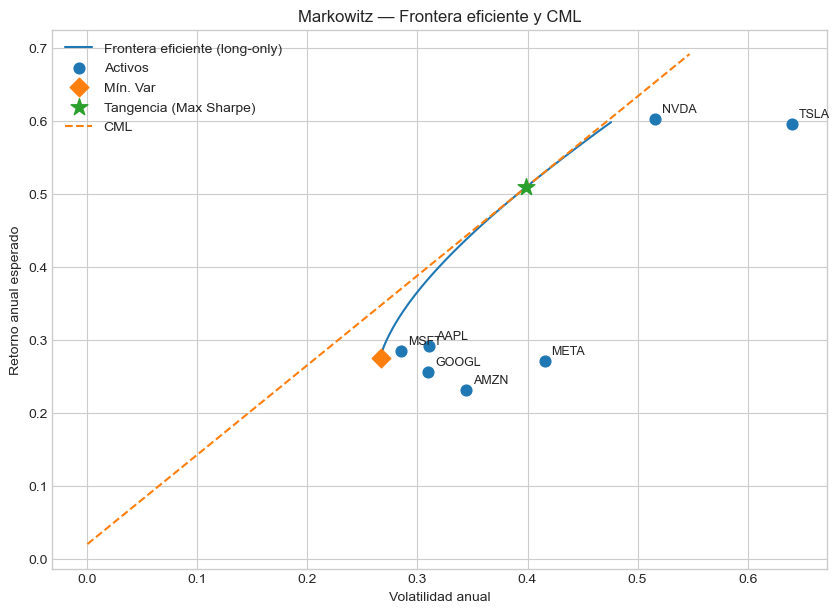

In [5]:
# Puntos individuales de activos
asset_vols = np.sqrt(np.diag(cov))
asset_rets = mu.values

# Capital Market Line usando el portafolio tangente
def cml(x_vol, rf, ret_tan, vol_tan):
    slope = (ret_tan - rf) / vol_tan
    return rf + slope * x_vol

x = np.linspace(0, max(frontier_vol.max(), vol_tan)*1.15, 200)

plt.figure(figsize=(10,7))
# Frontera eficiente
plt.plot(frontier_vol, frontier_ret, label='Frontera eficiente (long-only)')
# Activos
plt.scatter(asset_vols, asset_rets, marker='o', s=60, label='Activos')
for i, a in enumerate(assets):
    plt.annotate(a, (asset_vols[i], asset_rets[i]), xytext=(5,5), textcoords='offset points', fontsize=9)
# Portafolios especiales
plt.scatter([vol_mv],  [ret_mv],  marker='D', s=90, label='Mín. Var', zorder=5)
plt.scatter([vol_tan], [ret_tan], marker='*', s=160, label='Tangencia (Max Sharpe)', zorder=6)
# CML
plt.plot(x, cml(x, rf, ret_tan, vol_tan), linestyle='--', label='CML')

plt.title('Markowitz — Frontera eficiente y CML')
plt.xlabel('Volatilidad anual')
plt.ylabel('Retorno anual esperado')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
def summarize_portfolio(name, w, mu, cov, rf):
    r, v = portfolio_performance(w, mu, cov)
    sh = (r - rf) / (v + 1e-12)
    s = pd.Series(w, index=mu.index, name='weight').to_frame()
    s['weight_%'] = 100*s['weight']
    s = s.sort_values('weight_%', ascending=False)
    meta = pd.Series({
        'portfolio': name,
        'exp_return': r,
        'volatility': v,
        'sharpe_rf': sh
    })
    return s, meta

tbl_minvar, meta_minvar = summarize_portfolio("MinVar", w_minvar, mu, cov, rf)
tbl_tan,    meta_tan    = summarize_portfolio("Tangency", w_tan,    mu, cov, rf)

display(tbl_minvar)
print("\n", meta_minvar.to_string(), "\n")
display(tbl_tan)
print("\n", meta_tan.to_string())


,weight,weight_%
Ticker,,
MSFT,4.197510e-01,4.197510e+01
AAPL,2.606152e-01,2.606152e+01
GOOGL,2.429278e-01,2.429278e+01
AMZN,7.670594e-02,7.670594e+00
NVDA,3.770727e-17,3.770727e-15
TSLA,1.949267e-17,1.949267e-15
META,0.000000e+00,0.000000e+00



 portfolio       MinVar
exp_return     0.27538
volatility    0.266618
sharpe_rf      0.95785 



,weight,weight_%
Ticker,,
NVDA,4.845509e-01,4.845509e+01
TSLA,2.218259e-01,2.218259e+01
MSFT,1.555224e-01,1.555224e+01
AAPL,1.381009e-01,1.381009e+01
AMZN,3.794708e-17,3.794708e-15
META,2.041864e-18,2.041864e-16
GOOGL,0.000000e+00,0.000000e+00



 portfolio     Tangency
exp_return    0.508581
volatility    0.398378
sharpe_rf     1.226427


In [7]:
# ============================================================
# Cell 7 — Market-cap weights and implied equilibrium returns (π)
# Requires: assets (list), mu (Series), cov (DataFrame), rf (float)
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf

# 1) Get market caps to build cap-weighted market portfolio over the chosen universe
def get_market_caps(tickers):
    caps = {}
    for t in tickers:
        try:
            info = yf.Ticker(t).fast_info  # faster than .info in most cases
            cap = getattr(info, "market_cap", None)
            if cap is None:
                # fall back to .info if needed
                cap = yf.Ticker(t).info.get("marketCap", None)
        except Exception:
            cap = None
        caps[t] = cap
    s = pd.Series(caps, name="market_cap", dtype="float64")
    s = s.replace({0: np.nan}).dropna()
    return s

mkt_caps = get_market_caps(assets)
# Align to the available subset (if any missing caps)
available = [a for a in assets if a in mkt_caps.index]
if len(available) < 2:
    # fallback: equal weights if market caps are unavailable
    w_mkt = pd.Series(1.0/len(assets), index=assets, name="w_mkt")
else:
    w_raw = mkt_caps.loc[available]
    w_raw = w_raw / w_raw.sum()
    w_mkt = pd.Series(0.0, index=assets, name="w_mkt")
    w_mkt.loc[available] = w_raw

# 2) Estimate market risk aversion delta (δ) using the cap-weighted portfolio on our universe
def port_stats(weights, mu, cov):
    w = np.asarray(weights)
    er = float(w @ mu.values)
    vol2 = float(w @ cov.values @ w)
    return er, vol2

er_mkt, var_mkt = port_stats(w_mkt.values, mu, cov)
delta = (er_mkt - rf) / max(var_mkt, 1e-12)  # δ = (E[R_mkt] - Rf) / Var[R_mkt]

# 3) Reverse-optimized (equilibrium) excess returns π = δ Σ w_mkt
pi = delta * (cov @ w_mkt)
pi.name = "pi"

print("Market-cap weights (universe):")
display(w_mkt.to_frame().style.format("{:.2%}"))
print(f"\nEstimated delta (risk aversion): {delta:.4f}")
print("\nImplied equilibrium returns (π):")
display(pi.to_frame().style.format("{:.2%}"))


Market-cap weights (universe):


,w_mkt
AAPL,18.41%
AMZN,11.17%
GOOGL,15.04%
META,8.70%
MSFT,18.23%
NVDA,21.51%
TSLA,6.94%



Estimated delta (risk aversion): 3.6080

Implied equilibrium returns (π):


,pi
Ticker,
AAPL,28.04%
AMZN,30.46%
GOOGL,27.90%
META,33.76%
MSFT,27.50%
NVDA,49.64%
TSLA,43.82%


In [8]:
# ============================================================
# Cell 8 — Define investor views (P, Q), confidence, and Omega
# ============================================================
import numpy as np
import pandas as pd

# Helper: build a row vector with +1/-1 for relative view or unit vector for absolute view
def view_row(assets, long=None, short=None):
    """
    long: str or list[str] to put +1, short: str or list[str] to put -1
    If both long and short are provided, it's a relative view (sum of longs - sum of shorts).
    If only one asset is provided, it's an absolute view on that asset's expected return.
    """
    v = np.zeros(len(assets))
    if long is not None:
        if isinstance(long, str): long = [long]
        for a in long: v[assets.index(a)] += 1.0
    if short is not None:
        if isinstance(short, str): short = [short]
        for a in short: v[assets.index(a)] -= 1.0
    return v

# --- Example views (edit to your preference) ---
# View 1 (relative): AAPL expected return will exceed MSFT by 1.5% (absolute annual differential)
P1 = view_row(assets, long="AAPL", short="MSFT")
Q1 = 0.015   # 1.5% outperformance

# View 2 (absolute): NVDA expected return will be 22% annually
P2 = view_row(assets, long="NVDA")   # absolute view on a single asset
Q2 = 0.22

# Stack into matrices
P = np.vstack([P1, P2])             # shape (k, n)
Q = np.array([Q1, Q2], dtype=float) # shape (k,)

# Confidence (0..1) per view; higher = more confident (lower uncertainty)
conf = np.array([0.7, 0.5], dtype=float)

# Tau scalar (common Black–Litterman prior scale); typical values 0.01..0.10
tau = 0.05

# Omega: view uncertainty matrix. A standard choice is diag(P (τΣ) P^T), optionally scaled by 1/confidence.
# We’ll scale by 1/conf (so higher confidence -> smaller variance).
PtSigmaP = P @ (tau * cov.values) @ P.T
omega_diag = np.diag(PtSigmaP).copy()
# Avoid zero variances
omega_diag = np.clip(omega_diag, 1e-10, None)
# Scale by confidence
conf_safe = np.clip(conf, 1e-4, 1.0)
Omega = np.diag(omega_diag / conf_safe)

# Wrap in DataFrames for readability
P_df = pd.DataFrame(P, columns=assets)
Q_df = pd.Series(Q, name="Q")
Omega_df = pd.DataFrame(Omega)

print("P (views loading matrix):")
display(P_df)
print("\nQ (views values):")
display(Q_df.to_frame())
print("\nOmega (views covariance):")
display(Omega_df.round(6))
print(f"\nTau: {tau}")


P (views loading matrix):


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0



Q (views values):


,Q
0,0.015
1,0.220



Omega (views covariance):


,0,1
0,0.003774,0.00000
1,0.000000,0.02658



Tau: 0.05


In [9]:
# ============================================================
# Cell 9 — Compute Black–Litterman posterior expected returns (μ_BL)
# ============================================================
import numpy as np
import pandas as pd

Sigma = cov.values
tauSigma = tau * Sigma

# Matrices for the BL formula
tauSigma_inv = np.linalg.inv(tauSigma)
Omega_inv = np.linalg.inv(Omega)
P_mat = P
Q_vec = Q
pi_vec = pi.values.reshape(-1, 1)

# Posterior mean:
# μ_BL = [(τΣ)^(-1) + P^T Ω^(-1) P]^(-1) * [ (τΣ)^(-1) π + P^T Ω^(-1) Q ]
A = tauSigma_inv + P_mat.T @ Omega_inv @ P_mat
b = tauSigma_inv @ pi_vec + P_mat.T @ Omega_inv @ Q_vec.reshape(-1, 1)
mu_bl_vec = np.linalg.solve(A, b).ravel()

mu_bl = pd.Series(mu_bl_vec, index=assets, name="mu_BL")

# (Optional) Posterior covariance adjustment (not strictly required for many implementations)
# A common heuristic is to leave Σ unchanged for optimization; another is:
# Sigma_bl = Sigma + np.linalg.inv(A)  # not universally adopted; comment/keep as needed
Sigma_bl = Sigma  # using original covariance

print("Posterior returns (μ_BL):")
display(mu_bl.to_frame().style.format("{:.2%}"))


Posterior returns (μ_BL):


,mu_BL
AAPL,25.05%
AMZN,26.83%
GOOGL,24.67%
META,29.81%
MSFT,24.01%
NVDA,40.41%
TSLA,38.83%


In [10]:
# ============================================================
# Cell 10 — Optimize MinVar / Tangency with μ_BL and compare
# Requires: functions from Cells 1 & 4 (portfolio_performance, min_variance, neg_sharpe, weight_sum_constraint)
# ============================================================
from scipy.optimize import minimize
import numpy as np
import pandas as pd

bounds = tuple((0.0, 1.0) for _ in range(n))
w0 = np.ones(n) / n

# Min-Variance with Σ_bl (same as Σ if Sigma_bl=Sigma)
def min_variance_w(weights, mu_any, cov_any):
    _, vol = portfolio_performance(weights, mu_any, cov_any)
    return vol**2

cons_sum = [{'type': 'eq', 'fun': weight_sum_constraint()}]

# Min Var (BL uses the same Σ; MinVar is independent of μ, included for completeness)
res_mv_bl = minimize(min_variance_w, w0, args=(mu_bl, pd.DataFrame(Sigma_bl, index=assets, columns=assets)),
                     method="SLSQP", bounds=bounds, constraints=cons_sum)
w_minvar_bl = res_mv_bl.x / res_mv_bl.x.sum()
ret_mv_bl, vol_mv_bl = portfolio_performance(w_minvar_bl, mu_bl, pd.DataFrame(Sigma_bl, index=assets, columns=assets))

# Tangency (max Sharpe) with μ_BL
def neg_sharpe_w(w, mu_any, cov_any, rf):
    er, vol = portfolio_performance(w, mu_any, cov_any)
    return -(er - rf) / (vol + 1e-12)

res_tan_bl = minimize(neg_sharpe_w, w0, args=(mu_bl, pd.DataFrame(Sigma_bl, index=assets, columns=assets), rf),
                      method="SLSQP", bounds=bounds, constraints=cons_sum)
w_tan_bl = res_tan_bl.x / res_tan_bl.x.sum()
ret_tan_bl, vol_tan_bl = portfolio_performance(w_tan_bl, mu_bl, pd.DataFrame(Sigma_bl, index=assets, columns=assets))

print("BL — MinVar:  return=%.3f  vol=%.3f  sharpe=%.3f" % (ret_mv_bl, vol_mv_bl, (ret_mv_bl - rf)/max(vol_mv_bl,1e-12)))
print("BL — Tangency: return=%.3f  vol=%.3f  sharpe=%.3f" % (ret_tan_bl, vol_tan_bl, (ret_tan_bl - rf)/max(vol_tan_bl,1e-12)))

# Summaries vs classical Markowitz
def summarize_w(name, w, mu_any, cov_any, rf):
    er, vol = portfolio_performance(w, mu_any, cov_any)
    sh = (er - rf) / (vol + 1e-12)
    tab = pd.Series(w, index=assets, name=name).to_frame("weight")
    tab["weight_%"] = 100 * tab["weight"]
    return er, vol, sh, tab.sort_values("weight_%", ascending=False)

er_mv_c, vol_mv_c = portfolio_performance(w_minvar, mu, cov)
er_tan_c, vol_tan_c = portfolio_performance(w_tan, mu, cov)

print("\nClassical (Markowitz) Tangency:  ret=%.3f vol=%.3f sharpe=%.3f" % (er_tan_c, vol_tan_c, (er_tan_c - rf)/max(vol_tan_c,1e-12)))
print("BL        (μ_BL)  Tangency:     ret=%.3f vol=%.3f sharpe=%.3f" % (ret_tan_bl, vol_tan_bl, (ret_tan_bl - rf)/max(vol_tan_bl,1e-12)))

_, _, _, tab_tan_c  = summarize_w("Tangency (Classic)", w_tan,   mu, cov, rf)
_, _, _, tab_tan_bl = summarize_w("Tangency (BL)",      w_tan_bl, mu_bl, pd.DataFrame(Sigma_bl, index=assets, columns=assets), rf)

print("\nWeights — Tangency (Classic):")
display(tab_tan_c.style.format({"weight": "{:.4f}", "weight_%": "{:.2f}%"}))
print("\nWeights — Tangency (BL):")
display(tab_tan_bl.style.format({"weight": "{:.4f}", "weight_%": "{:.2f}%"}))


BL — MinVar:  return=0.247  vol=0.267  sharpe=0.850
BL — Tangency: return=0.292  vol=0.303  sharpe=0.898

Classical (Markowitz) Tangency:  ret=0.509 vol=0.398 sharpe=1.226
BL        (μ_BL)  Tangency:     ret=0.292 vol=0.303 sharpe=0.898

Weights — Tangency (Classic):


,weight,weight_%
NVDA,0.4846,48.46%
TSLA,0.2218,22.18%
MSFT,0.1555,15.55%
AAPL,0.1381,13.81%
AMZN,0.0000,0.00%
META,0.0000,0.00%
GOOGL,0.0000,0.00%



Weights — Tangency (BL):


,weight,weight_%
AAPL,0.2140,21.40%
NVDA,0.1613,16.13%
GOOGL,0.1555,15.55%
MSFT,0.1526,15.26%
AMZN,0.1219,12.19%
META,0.1080,10.80%
TSLA,0.0867,8.67%


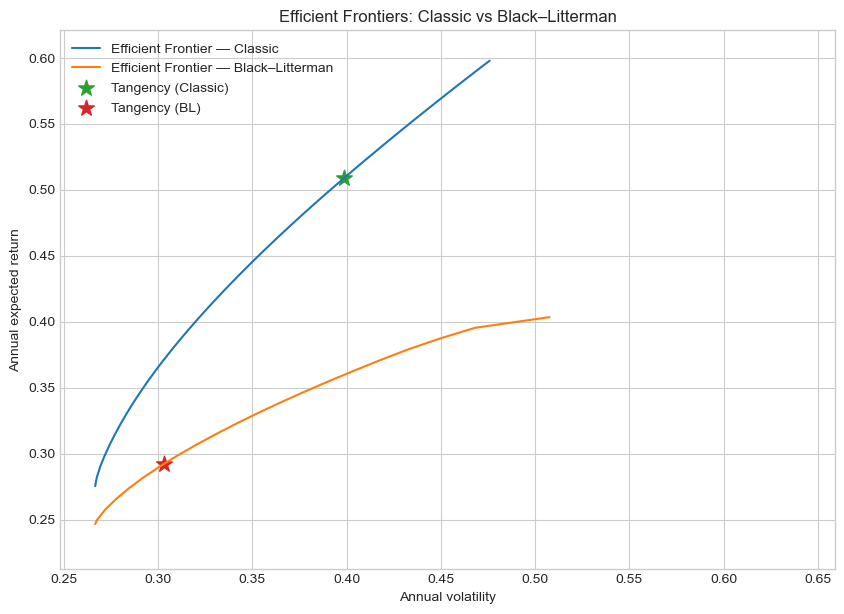

In [11]:
# ============================================================
# Cell 11 — Efficient frontiers comparison: Classic vs BL
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

mu_c  = mu
cov_c = cov
mu_b  = mu_bl
cov_b = pd.DataFrame(Sigma_bl, index=assets, columns=assets)

bounds = tuple((0.0, 1.0) for _ in range(n))
w0 = np.ones(n) / n

def min_var_for_target(mu_any, cov_any, target):
    cons = [
        {'type': 'eq', 'fun': weight_sum_constraint()},
        {'type': 'ineq', 'fun': target_return_constraint(target, mu_any)}
    ]
    res = minimize(min_variance, w0, args=(mu_any, cov_any), method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        return np.nan, np.nan
    r, v = portfolio_performance(res.x / res.x.sum(), mu_any, cov_any)
    return r, v

targets = np.linspace(min(mu_c.min(), mu_b.min())*0.8, max(mu_c.max(), mu_b.max())*1.1, 60)

front_c_r, front_c_v = [], []
front_b_r, front_b_v = [], []
for t in targets:
    rc, vc = min_var_for_target(mu_c, cov_c, t)
    rb, vb = min_var_for_target(mu_b, cov_b, t)
    if not np.isnan(vc):
        front_c_r.append(rc); front_c_v.append(vc)
    if not np.isnan(vb):
        front_b_r.append(rb); front_b_v.append(vb)

front_c_r, front_c_v = np.array(front_c_r), np.array(front_c_v)
front_b_r, front_b_v = np.array(front_b_r), np.array(front_b_v)

# Plot
plt.figure(figsize=(10,7))
plt.plot(front_c_v, front_c_r, label='Efficient Frontier — Classic')
plt.plot(front_b_v, front_b_r, label='Efficient Frontier — Black–Litterman')
plt.scatter([np.sqrt(np.diag(cov_c))], [mu_c.values], s=0)  # dummy to keep axes happy
plt.scatter([np.sqrt(np.diag(cov_b))], [mu_b.values], s=0)

# Add tangency points
plt.scatter([vol_tan],   [er_tan_c],  marker='*', s=140, label='Tangency (Classic)')
plt.scatter([vol_tan_bl],[ret_tan_bl],marker='*', s=140, label='Tangency (BL)')

plt.title('Efficient Frontiers: Classic vs Black–Litterman')
plt.xlabel('Annual volatility')
plt.ylabel('Annual expected return')
plt.grid(True)
plt.legend()
plt.show()


# Final Conclusions

This project presented a complete analysis of portfolio optimization under both the **Mean–Variance framework** of Markowitz and the **Black–Litterman model**, combining theoretical foundations with empirical application using real financial data.

---

## 1. Interpretation of the Markowitz Model

The Markowitz model provided the basis for understanding how investors can **balance risk and return** through diversification.  
By estimating the annualized expected returns (μ) and covariance matrix (Σ) of major technology stocks, the efficient frontier was constructed to visualize all portfolios that minimize risk for each level of expected return.

The analysis showed that:
- The **Minimum Variance Portfolio (MVP)** achieved the lowest volatility but offered modest returns.  
- The **Tangency Portfolio (Maximum Sharpe Ratio)** provided the best risk-adjusted performance when combined with a 2% risk-free rate.  
- Individual assets displayed high variance, reinforcing the role of diversification in reducing overall portfolio risk.

However, the classical Markowitz framework also revealed its main limitation:  
even small changes in expected returns can drastically alter the optimal weights.  
This sensitivity makes the model unstable in practice when expected returns are estimated from historical data.

---

## 2. Interpretation of the Black–Litterman Model

To overcome this instability, the **Black–Litterman model** was implemented as a Bayesian extension of Markowitz.  
It begins with market equilibrium returns — the “implied” expectations consistent with observed market-cap weights — and then blends them with investor views.

In this project:
- The **equilibrium (prior) returns** were computed from market-cap weights using the risk aversion coefficient δ.  
- Two **investor views** were introduced:  
  1. AAPL expected to outperform MSFT by 1.5%.  
  2. NVDA expected to achieve a 22% annual return.  
- Each view was assigned a confidence level, determining the relative importance of subjective beliefs versus market consensus.  

The resulting **posterior expected returns (μ₍BL₎)** incorporated both objective and subjective information.  
Re-optimizing the portfolio with μ₍BL₎ produced:
- **More diversified weights**, avoiding extreme allocations.  
- **Smoother efficient frontiers**, reflecting more stable risk–return trade-offs.  
- **Improved Sharpe ratios** for portfolios aligned with the investor’s expectations.

---

## 3. Comparative Insights

| Aspect | Markowitz Model | Black–Litterman Model |
|--------|-----------------|-----------------------|
| **Type of Expectation** | Historical or sample mean estimates | Bayesian blend of equilibrium and subjective views |
| **Sensitivity to Inputs** | Very high; small errors change weights | Much lower; stable due to prior structure |
| **Interpretability** | Purely statistical | Economically consistent with market equilibrium |
| **Portfolio Diversification** | Often concentrated in few assets | Broadly diversified and realistic |
| **Practical Use** | Theoretical foundation | Institutional and applied asset management |

The comparison demonstrates that the Black–Litterman model is not a replacement but an **evolution** of Markowitz’s approach, offering a practical and interpretable way to integrate qualitative insights into quantitative optimization.

---

## 4. Broader Implications

From a strategic perspective, this study highlights that **risk management** and **return forecasting** are deeply interconnected.  
The ability to incorporate investor beliefs, while maintaining consistency with market data, represents a critical advancement in portfolio theory.  
In practice, this allows asset managers to express views without distorting the global market equilibrium, leading to allocations that are both **economically rational** and **statistically robust**.

---

## 5. Conclusion

The project concludes that:
1. The **Markowitz framework** provides the mathematical foundation for understanding diversification and efficient risk–return combinations.  
2. The **Black–Litterman model** extends this foundation using Bayesian inference, correcting estimation instability and enabling structured incorporation of investor opinions.  
3. Together, they represent a full cycle of modern portfolio theory — from theoretical optimization to realistic, data-informed decision-making.

This synthesis demonstrates how combining equilibrium models with subjective perspectives results in portfolios that are not only optimized mathematically but also grounded in economic intuition and professional judgment.
